In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


In [3]:
import os 

csv_path = 'fake_job_postings.csv' # -> download from Kaggle

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Dataset not found.")   

df = pd.read_csv(csv_path)
print(f"Dataset loaded successfully. Shape: {df.shape}")

Dataset loaded successfully. Shape: (17880, 18)


In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df = df[['title', 'location', 'description', 'requirements', 'fraudulent']]
cleaned_df = df.dropna()

In [30]:
print(cleaned_df.duplicated().sum())
cleaned_df.drop_duplicates(inplace=True)

360


C:\Users\mdmee\AppData\Local\Temp\ipykernel_14780\2606892413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop_duplicates(inplace=True)


In [117]:
X = cleaned_df[['title', 'location', 'description', 'requirements']]
X_text = X.astype(str).agg(" ".join, axis=1)
y = cleaned_df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=1)

In [118]:
RFCpipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=1)),
    ('model', RandomForestClassifier(random_state=1))
])

XGBPipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=1)),
    ('model', XGBClassifier())
])

NBPipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=1)),
    ('model', MultinomialNB())
])

In [ ]:
# Random Forest Classifier

RFCgridsearch = GridSearchCV(
    RFCpipeline,
    param_grid={
        'tfidf__max_features': [9000],
        'tfidf__min_df': [1],

        'smote__k_neighbors': [10, 15], 

        'model__n_estimators': [100],
        'model__max_depth': [100]
    },
    cv=3,
    n_jobs=-1,
    scoring='recall'
)

RFCgridsearch.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__max_depth': [100], 'model__n_estimators': [100, 150], 'smote__k_neighbors': [10, 15], 'tfidf__max_features': [9000], ...}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [ ]:
# XGBoost Classifier

XGBgridsearch = RandomizedSearchCV(
    XGBPipeline,
    param_distributions={
        'tfidf__max_features': [6000, 7000],
        'tfidf__min_df': [1],

        'smote__k_neighbors': [12, 15], 

        'model__learning_rate': [0.1],
        'model__n_estimators': [100],
        'model__max_depth': [6]
    },
    cv=3,
    n_jobs=-1,      
    scoring='recall'
)

XGBgridsearch.fit(X_train, y_train)

C:\Users\mdmee\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'smote__k_neighbors': [12, 15], 'tfidf__max_features': [6000, 7000]}"
,n_iter,10
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [143]:
from sklearn.metrics import precision_score, recall_score, make_scorer

def weighted_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return 0.55 * recall + 0.45 * precision

weighted_scorer = make_scorer(weighted_recall_precision, greater_is_better=True)

In [150]:
# Naive Bayes

NBgridsearch = GridSearchCV(
    NBPipeline,
    param_grid={
        'tfidf__max_features': [20000, 25000],
        'tfidf__min_df': [1],

        'smote__k_neighbors': [12], 

        'model__alpha' : [0.5, 1, 2]
    },
    cv=3,
    n_jobs=-1,      
    scoring= {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'weighted': weighted_scorer
    },
    refit='weighted'
)

NBgridsearch.fit(X_train, y_train)

,estimator,Pipeline(step...inomialNB())])
,param_grid,"{'model__alpha': [0.5, 1, ...], 'smote__k_neighbors': [12], 'tfidf__max_features': [20000, 25000], 'tfidf__min_df': [1]}"
,scoring,"{'precision': make_scorer(p...hod='predict'), 'recall': make_scorer(r...hod='predict'), 'weighted': make_scorer(w...hod='predict')}"
,n_jobs,-1
,refit,'weighted'
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [151]:
print("Best Params:", NBgridsearch.best_params_)
print("Best CV Score:", NBgridsearch.best_score_)

Best Params: {'model__alpha': 0.5, 'smote__k_neighbors': 12, 'tfidf__max_features': 25000, 'tfidf__min_df': 1}
Best CV Score: 0.6261918706707393


In [152]:
NBgridsearch.cv_results_

{'mean_fit_time': array([5.72966059, 4.87672639, 4.61764606, 4.75315809, 4.64635817,
        4.02133505]),
 'std_fit_time': array([0.04972527, 0.44815676, 0.06015834, 0.07419563, 0.093863  ,
        0.34900846]),
 'mean_score_time': array([2.07411337, 2.05903419, 2.13187774, 2.4499263 , 2.34457366,
        1.99292517]),
 'std_score_time': array([0.01985584, 0.03993587, 0.0421835 , 0.03011272, 0.0410939 ,
        0.21862774]),
 'param_model__alpha': masked_array(data=[0.5, 0.5, 1.0, 1.0, 2.0, 2.0],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'param_smote__k_neighbors': masked_array(data=[12, 12, 12, 12, 12, 12],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'param_tfidf__max_features': masked_array(data=[20000, 25000, 20000, 25000, 20000, 25000],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'param_tfidf__min_df': masked_array(data=[1, 1, 1, 1, 1, 1]

In [153]:
pred = NBgridsearch.predict(X_test)

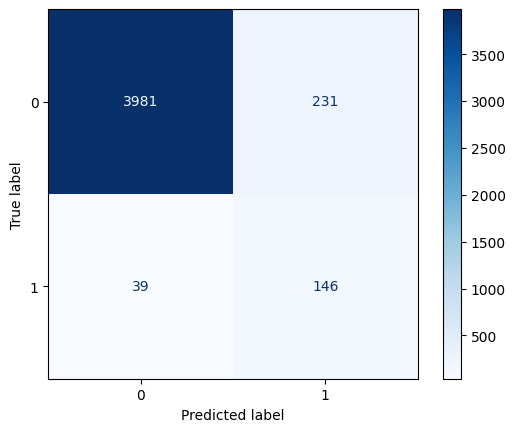

In [154]:
cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=NBgridsearch.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [155]:
report=classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4212
           1       0.39      0.79      0.52       185

    accuracy                           0.94      4397
   macro avg       0.69      0.87      0.74      4397
weighted avg       0.96      0.94      0.95      4397



In [156]:
import joblib
joblib.dump(NBgridsearch,"scam_prediction_model.pkl")

['scam_prediction_model.pkl']

In [157]:
# I apologize for the messy code